#  1. Dataset Download (KaggleHub):

In [ ]:
import kagglehub
import os

path = kagglehub.dataset_download(
    "masoudnickparvar/brain-tumor-mri-dataset"
)

TRAIN_DIR = os.path.join(path, "Training")
TEST_DIR  = os.path.join(path, "Testing")

print("Training classes:", os.listdir(TRAIN_DIR))
print("Testing classes :", os.listdir(TEST_DIR))


Using Colab cache for faster access to the 'brain-tumor-mri-dataset' dataset.
Training classes: ['pituitary', 'notumor', 'meningioma', 'glioma']
Testing classes : ['pituitary', 'notumor', 'meningioma', 'glioma']


# 2. Imports & Device

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


# 3. Transforms (RESNET-18 STANDARD)


In [ ]:
train_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std =[0.229, 0.224, 0.225]
    )
])

test_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std =[0.229, 0.224, 0.225]
    )
])


# 4. Dataset & DataLoaders


In [ ]:
full_train_dataset = datasets.ImageFolder(TRAIN_DIR, transform=train_transforms)
test_dataset       = datasets.ImageFolder(TEST_DIR,  transform=test_transforms)

class_names = full_train_dataset.classes
num_classes = len(class_names)
print("Classes:", class_names)
train_size = int(0.8 * len(full_train_dataset))
val_size   = len(full_train_dataset) - train_size

generator = torch.Generator().manual_seed(42)
train_dataset, val_dataset = random_split(
    full_train_dataset, [train_size, val_size], generator=generator
)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False)


Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


# 5. Class Distribution (EDA)

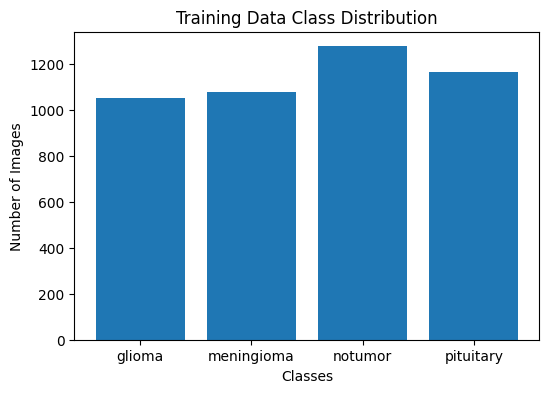

In [ ]:
labels = [label for _, label in train_dataset]
label_count = Counter(labels)

plt.figure(figsize=(6,4))
plt.bar(class_names, [label_count[i] for i in range(len(class_names))])
plt.title("Training Data Class Distribution")
plt.xlabel("Classes")
plt.ylabel("Number of Images")
plt.show()



# 6. Load PRETRAINED RESNET-18

In [ ]:
model = models.resnet18(pretrained=True)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 188MB/s]


In [ ]:
num_ftrs = model.fc.in_features

model.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(num_ftrs, num_classes)
)

model = model.to(device)
print(model)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# 7. Loss, Optimizer & Scheduler

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(
    model.parameters(),
    lr=0.001,
)


# 8. Training Function

In [ ]:
def train_model(epochs=10):
    train_accs, val_accs, test_accs = [], [], []
    train_losses, val_losses, test_losses = [], [], []

    for epoch in range(epochs):

        # ===== TRAIN =====
        model.train()
        correct, total, running_loss = 0, 0, 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_acc = 100 * correct / total
        train_loss = running_loss / len(train_loader)

        # ===== VALIDATION =====
        model.eval()
        correct, total, running_loss = 0, 0, 0.0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                running_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        val_acc = 100 * correct / total
        val_loss = running_loss / len(val_loader)

        # ===== TEST =====
        correct, total, running_loss = 0, 0, 0.0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                running_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)

        test_acc = 100 * correct / total
        test_loss = running_loss / len(test_loader)

        # ===== SAVE METRICS =====
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        test_accs.append(test_acc)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        test_losses.append(test_loss)

        print(f"Epoch [{epoch+1}/{epochs}] | "
              f"Train Acc: {train_acc:.2f}% | "
              f"Val Acc: {val_acc:.2f}% | "
              f"Test Acc: {test_acc:.2f}% | "
              f"Train Loss: {train_loss:.4f} | "
              f"Val Loss: {val_loss:.4f} | "
              f"Test Loss: {test_loss:.4f}")

    return train_accs, val_accs, test_accs, train_losses, val_losses, test_losses


Epoch [1/10] | Train Acc: 92.12% | Val Acc: 85.83% | Test Acc: 86.80% | Train Loss: 0.2247 | Val Loss: 0.3958 | Test Loss: 0.3776
Epoch [2/10] | Train Acc: 94.27% | Val Acc: 93.26% | Test Acc: 92.68% | Train Loss: 0.1740 | Val Loss: 0.1698 | Test Loss: 0.1910
Epoch [3/10] | Train Acc: 94.64% | Val Acc: 95.63% | Test Acc: 96.57% | Train Loss: 0.1605 | Val Loss: 0.1310 | Test Loss: 0.1156
Epoch [4/10] | Train Acc: 95.97% | Val Acc: 94.84% | Test Acc: 96.64% | Train Loss: 0.1135 | Val Loss: 0.1328 | Test Loss: 0.0926
Epoch [5/10] | Train Acc: 95.80% | Val Acc: 85.13% | Test Acc: 84.67% | Train Loss: 0.1291 | Val Loss: 0.4085 | Test Loss: 0.4205
Epoch [6/10] | Train Acc: 96.50% | Val Acc: 93.44% | Test Acc: 94.51% | Train Loss: 0.1019 | Val Loss: 0.1945 | Test Loss: 0.1499
Epoch [7/10] | Train Acc: 96.45% | Val Acc: 93.96% | Test Acc: 93.52% | Train Loss: 0.0968 | Val Loss: 0.2115 | Test Loss: 0.2009
Epoch [8/10] | Train Acc: 97.64% | Val Acc: 96.76% | Test Acc: 96.72% | Train Loss: 0.0685

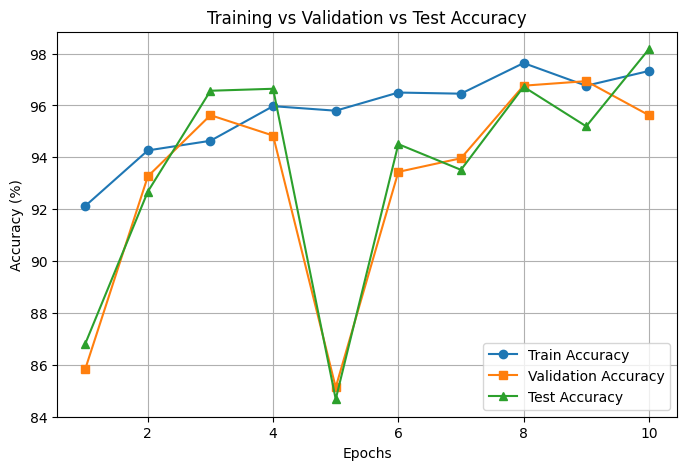

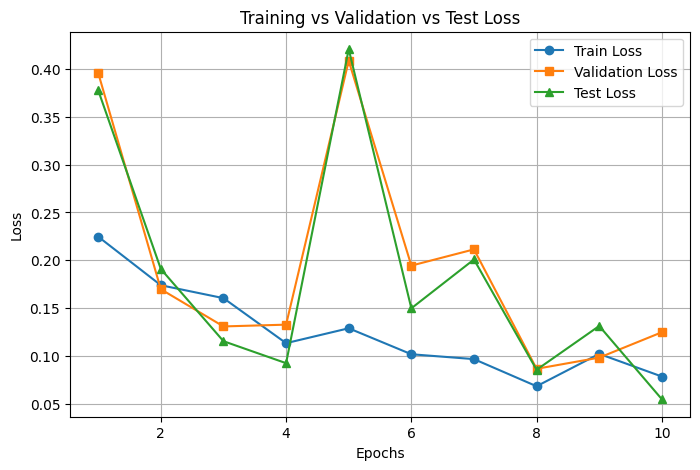

In [ ]:
EPOCHS = 10
train_accs, val_accs, test_accs, train_losses, val_losses, test_losses = train_model(EPOCHS)

# Plot accuracy curves
epochs = range(1, EPOCHS+1)
plt.figure(figsize=(8,5))
plt.plot(epochs, train_accs, marker='o', label="Train Accuracy")
plt.plot(epochs, val_accs, marker='s', label="Validation Accuracy")
plt.plot(epochs, test_accs, marker='^', label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Training vs Validation vs Test Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Plot loss curves
plt.figure(figsize=(8,5))
plt.plot(epochs, train_losses, marker='o', label="Train Loss")
plt.plot(epochs, val_losses, marker='s', label="Validation Loss")
plt.plot(epochs, test_losses, marker='^', label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation vs Test Loss")
plt.legend()
plt.grid(True)
plt.show()


# Confusion Matrix & Classification Report

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

all_preds, all_labels = [], []

model.eval()  # Set model to evaluation mode
with torch.no_grad():  # Disable gradient calculation
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)  # Get the predicted class index

        all_preds.extend(preds.cpu().numpy())  # Move to CPU and save predictions
        all_labels.extend(labels.numpy())      # Save true labels


# Confusion Matrix Plot

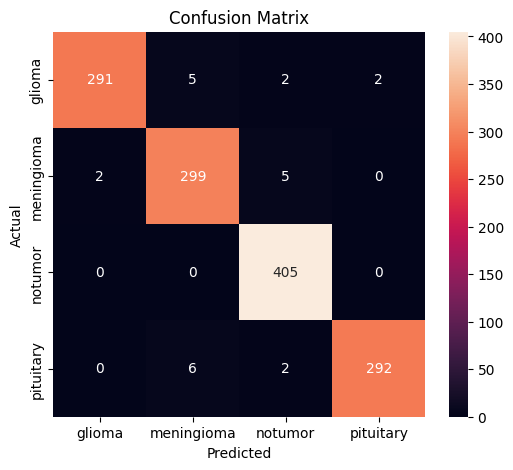

              precision    recall  f1-score   support

      glioma       0.99      0.97      0.98       300
  meningioma       0.96      0.98      0.97       306
     notumor       0.98      1.00      0.99       405
   pituitary       0.99      0.97      0.98       300

    accuracy                           0.98      1311
   macro avg       0.98      0.98      0.98      1311
weighted avg       0.98      0.98      0.98      1311



In [ ]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
# Classification Report
print(classification_report(all_labels, all_preds, target_names=class_names))


# Saving and Loading the Model

---



In [ ]:
torch.save(model.state_dict(), "brain_tumor_resnet18.pth")
print("Model saved successfully!")


Model saved successfully!


# Load

In [ ]:
model.load_state_dict(torch.load("brain_tumor_resnet18.pth"))
model.eval()  # Set to evaluation mode

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Predicting New Images

In [ ]:
from PIL import Image
from torchvision import transforms
import torch
from google.colab import files  # only in Colab, for desktop upload

# Function to predict image
def predict_image(img_path):
    img = Image.open(img_path).convert('L')  # Load as grayscale

    # Transform: resize, crop, convert to 3-channel, normalize for ResNet
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.Grayscale(num_output_channels=3),  # 3-channel for ResNet
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
    ])
    img = transform(img).unsqueeze(0).to(device)  # Add batch dimension

    model.eval()
    with torch.no_grad():
        output = model(img)
        _, pred = torch.max(output, 1)
        print(f"Predicted Class: {class_names[pred.item()]}")

# Upload image from desktop
uploaded = files.upload()  # Opens a file picker in Colab
for img_name in uploaded.keys():
    print(f"Uploaded file: {img_name}")
    predict_image(img_name)


Saving menin.jpg to menin.jpg
Uploaded file: menin.jpg
Predicted Class: meningioma


# Visualize Predictions

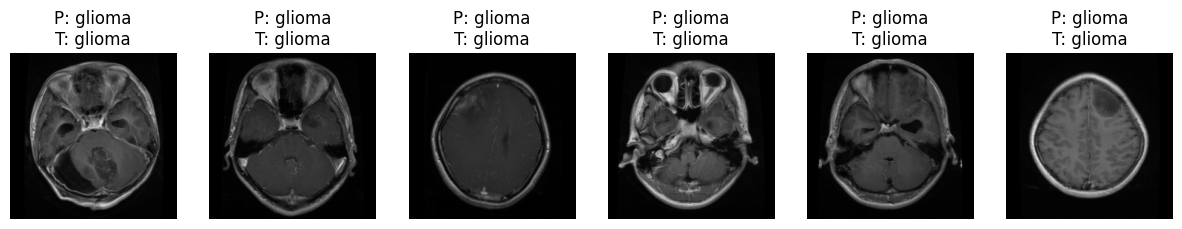

In [ ]:
import matplotlib.pyplot as plt
import torch

def visualize_predictions(num_images=6):
    # Get a batch from test loader
    images, labels = next(iter(test_loader))
    images, labels = images[:num_images].to(device), labels[:num_images].to(device)

    # Model predictions
    model.eval()
    with torch.no_grad():
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

    # Unnormalize the images (ImageNet mean & std)
    mean = torch.tensor([0.485, 0.456, 0.406]).view(1,3,1,1).to(device)
    std  = torch.tensor([0.229, 0.224, 0.225]).view(1,3,1,1).to(device)
    images_unnorm = images * std + mean

    # Plot
    fig, axes = plt.subplots(1, num_images, figsize=(15,3))
    for i in range(num_images):
        img = images_unnorm[i].cpu().permute(1,2,0)  # [H,W,3] for imshow
        img = torch.clamp(img, 0, 1)  # Ensure pixel values are in [0,1]
        axes[i].imshow(img)
        axes[i].set_title(f"P: {class_names[preds[i]]}\nT: {class_names[labels[i]]}")
        axes[i].axis("off")
    plt.show()

# Call the function
visualize_predictions()
